# Tutorial: Train and validate models
### 1. Load data and related packages
### 2. Train various models
#### 2.1 Train and tune LightGBM
#### 2.2 Visualize the results
#### 2.3 Save and load your Trainer
#### 2.4 Train other models
### 3. Cross validate models

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Load data and related packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

UCI Adult data are going to be used in this tutorial. The data contain both numerical and categorical features, and the target to predict is whether a person makes over 50K a year. It is a very simple binary classification task.

In [3]:
train = pd.read_csv('kuma_utils/datasets/adult_train.csv')
test = pd.read_csv('kuma_utils/datasets/adult_test.csv')

In [4]:
train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Let's prepare the data. We need to encode categorical features.

In [7]:
from xfeat import SelectCategorical, SelectNumerical, LabelEncoder
from kuma_utils.preprocessing.xfeat import Pipeline, TargetEncoder

In [8]:
num_enc = Pipeline([
    SelectNumerical(),
])

cat_enc = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix='')
], target_col='Target')

In [9]:
train_cat, train_num = cat_enc.fit_transform(train), num_enc.fit_transform(train)
categorical_index = list(range(train_cat.shape[1]))
train_encoded = pd.concat([train_cat, train_num], axis=1) 
train_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
0,0,0,0,0,0,0,0,0,0,39,77516,13,2174,0,40
1,1,0,1,1,1,0,0,0,0,50,83311,13,0,0,13
2,2,1,2,2,0,0,0,0,0,38,215646,9,0,0,40
3,2,2,1,2,1,1,0,0,0,53,234721,7,0,0,40
4,2,0,1,3,2,1,1,1,0,28,338409,13,0,0,40


Looks good to me. Let's apply the same transform to test data.

In [10]:
test_encoded = pd.concat([cat_enc.transform(test), num_enc.transform(test)], axis=1)
test_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
0,2,2,0,9,3,1,0,0,0,25,226802.0,7.0,0.0,0.0,40.0
1,2,1,1,8,1,0,0,0,0,38,89814.0,9.0,0.0,0.0,50.0
2,4,6,1,11,1,0,0,0,1,28,336951.0,12.0,0.0,0.0,40.0
3,2,5,1,9,1,1,0,0,1,44,160323.0,10.0,7688.0,0.0,40.0
4,-1,5,0,-1,3,0,1,0,0,18,103497.0,10.0,0.0,0.0,30.0


In [11]:
labels, features = train_encoded['Target'], train_encoded.drop('Target', axis=1)
labels_test, features_test = test_encoded['Target'], test_encoded.drop('Target', axis=1)

## 2. Train models
Before going to training, let's define our evaluation metric. Since the task is binary classification, I will use ROC-AUC for evaluation.

In [12]:
from sklearn.metrics import roc_auc_score, make_scorer
from kuma_utils.training import Trainer, auc_metric, acc_metric

### 2.1 Use Trainer

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

In [14]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

Logger created at 20/11/26:09:15:06
Training until validation scores don't improve for 50 rounds
[25]	training's auc: 0.932277	valid_1's auc: 0.920501
[50]	training's auc: 0.944298	valid_1's auc: 0.925333
[75]	training's auc: 0.951382	valid_1's auc: 0.92577
[100]	training's auc: 0.957066	valid_1's auc: 0.925686
[125]	training's auc: 0.961391	valid_1's auc: 0.926058
[150]	training's auc: 0.965348	valid_1's auc: 0.926008
[175]	training's auc: 0.968804	valid_1's auc: 0.925693
Early stopping, best iteration is:
[132]	training's auc: 0.962608	valid_1's auc: 0.926094


In [15]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 132
best_score: 0.9260938130953806

In [16]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9243319865484607

Also, Trainer class has a built-in optuna function. Just set `tune_model=True` and it will search the best hyperparameters. Don't forget to set `n_trials` or `timeout` to prevent endless tuning (For LightGBM models, tuning will finished by itself).

In [17]:
trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params, fit_params=fit_params, 
    tune_model=True
)

Logger created at 20/11/26:09:15:08
09:15:08 [trial    0] New best: 0.927057 
{'feature_fraction': 0.8999999999999999}
09:15:09 [trial    2] New best: 0.928950 
{'feature_fraction': 0.6}
09:15:10 [trial    3] New best: 0.929217 
{'feature_fraction': 0.5}
09:15:10 [trial    4] New best: 0.930116 
{'feature_fraction': 0.4}
09:15:12 [trial    7] New best: 0.926063 
{'num_leaves': 151}
09:15:13 [trial    8] New best: 0.926145 
{'num_leaves': 180}
09:15:14 [trial    9] New best: 0.926280 
{'num_leaves': 173}
09:15:14 [trial   10] New best: 0.930796 
{'num_leaves': 13}
09:15:33 [trial   27] New best: 0.929277 
{'bagging_fraction': 0.842011007779658, 'bagging_freq': 4}
09:15:36 [trial   30] New best: 0.929572 
{'bagging_fraction': 0.9462201262544149, 'bagging_freq': 1}
09:15:40 [trial   35] New best: 0.929585 
{'bagging_fraction': 0.9543588675063279, 'bagging_freq': 3}
09:15:42 [trial   37] New best: 0.930796 
{'feature_fraction': 0.44800000000000006}
09:15:43 [trial   38] New best: 0.930796 

In [18]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9275404960709888

In [19]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 207
best_score: 0.9307955609880759

Custom metrics are available.

In [20]:
from kuma_utils.metrics import SeWithFixedSp

params = {
    'objective': 'binary',
    'metric': 'SeWithFixedSp',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
    'feval': SeWithFixedSp(sp=0.9).lgbm
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

specify optimization direction for metric SeWithFixedSp.
Logger created at 20/11/26:09:16:05
Training until validation scores don't improve for 50 rounds
[25]	training's SeWithFixedSp: 0.770528	valid_1's SeWithFixedSp: 0.750161
[50]	training's SeWithFixedSp: 0.810312	valid_1's SeWithFixedSp: 0.763006
[75]	training's SeWithFixedSp: 0.830522	valid_1's SeWithFixedSp: 0.770071
[100]	training's SeWithFixedSp: 0.85105	valid_1's SeWithFixedSp: 0.763006
Early stopping, best iteration is:
[74]	training's SeWithFixedSp: 0.828771	valid_1's SeWithFixedSp: 0.770713


### 2.2 Visualize the results

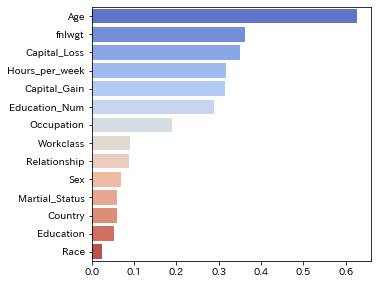

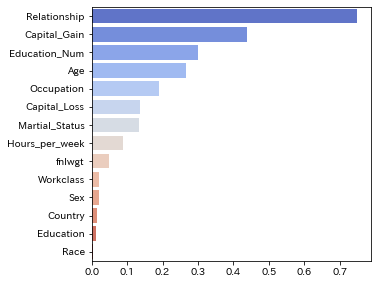

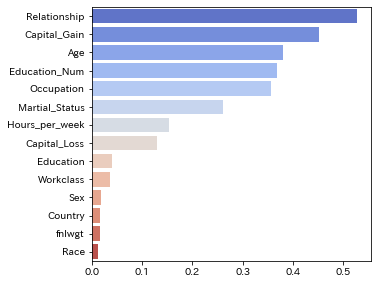

In [21]:
trn.plot_feature_importance()
trn.plot_feature_importance('gain')
trn.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

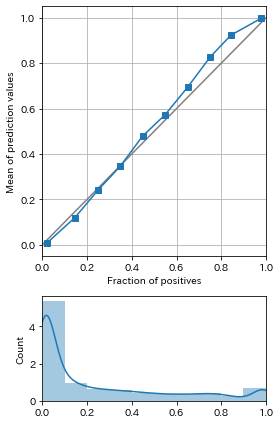

In [22]:
trn.plot_calibration_curve(data=(x_train, y_train))

### 2.3 Save and load Trainer

In [23]:
trn.save('lgbm0.trainer')
trn = Trainer(path='lgbm0.trainer')
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 74
best_score: 0.6615285806037251

### 2.4 Train other models

In [24]:
params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 500,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 50,
    'verbose_eval': 25
}

trn2 = Trainer(CatBoostClassifier)
trn2.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params,
    tune_model=True, n_trials=5,
    fit_params=fit_params)

Logger created at 20/11/26:09:16:16
09:16:20 [trial    0] New best: 0.912853 
{ 'boosting_type': 'Ordered',
  'bootstrap_type': 'Bernoulli',
  'colsample_bylevel': 0.021717225096721516,
  'depth': 3,
  'objective': 'Logloss',
  'subsample': 0.22422192592374385}
09:16:26 [trial    1] New best: 0.921082 
{ 'bagging_temperature': 3.001471423932791,
  'boosting_type': 'Plain',
  'bootstrap_type': 'Bayesian',
  'colsample_bylevel': 0.0798172564101858,
  'depth': 5,
  'objective': 'CrossEntropy'}
09:16:39 [trial    3] New best: 0.927375 
{ 'boosting_type': 'Ordered',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.08134344742180855,
  'depth': 7,
  'objective': 'Logloss'}


In [25]:
roc_auc_score(labels_test, trn2.smart_predict(features_test))

0.924345860042685

In [26]:
params = {}
fit_params = {}

trn3 = Trainer(LogisticRegression)
trn3.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    params=params,
    eval_metric=auc_metric, maximize=True,
    # tune_model=True, n_trials=5,
    fit_params=fit_params)

Logger created at 20/11/26:09:16:45
09:16:45 [None]	best score is 0.636627


In [27]:
roc_auc_score(labels_test, trn3.predict_proba(features_test)[:, 1])

0.639307498315212

## 3. Cross validate models

In [28]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
)

Logger created at 20/11/26:09:16:46
[25]	cv_agg's auc: 0.919932 + 0.00349363
[50]	cv_agg's auc: 0.9252 + 0.00314706
[75]	cv_agg's auc: 0.925487 + 0.00289121
[100]	cv_agg's auc: 0.925613 + 0.00290994
[125]	cv_agg's auc: 0.925751 + 0.00310033
[150]	cv_agg's auc: 0.925324 + 0.00304159
[175]	cv_agg's auc: 0.925018 + 0.00301846
09:16:48 [125]	best score is 0.925751


In [29]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 125
best_score: 0.9257509869339163

In [30]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0))

0.9264433713657352

**Note that Trainer.cv() is cross validation during training process.** The model is fit to the whole data rather than each fold. This returns models with same hyperparameters, but trained on different data.

In [31]:
from kuma_utils.training import CrossValidator

In [32]:
validator = CrossValidator(LGBMClassifier)
validator.train(
    data=(features, labels), params=params, fit_params=fit_params,
    folds=StratifiedKFold(n_splits=5)
)

Logger created at 20/11/26:09:16:48
09:16:48 [cv0] Starting fold 0
09:16:49 [cv0] Fold 0: eval=0.926061 (iter=127)
09:16:49 [cv0] Starting fold 1
09:16:50 [cv0] Fold 1: eval=0.925534 (iter=134)
09:16:50 [cv0] Starting fold 2
09:16:50 [cv0] Fold 2: eval=0.929985 (iter=89)
09:16:50 [cv0] Starting fold 3
09:16:51 [cv0] Fold 3: eval=0.929366 (iter=151)
09:16:51 [cv0] Starting fold 4
09:16:52 [cv0] Fold 4: eval=0.929537 (iter=122)
09:16:52 [cv0] Overall metric: 0.928097 + 0.001896


In [33]:
validator

CrossValidator: cv0
models: [Trainer: cv0_fold0
model: LGBMClassifier()
is_trained: True
best_iteration: 127
best_score: 0.9260606620794066
, Trainer: cv0_fold1
model: LGBMClassifier()
is_trained: True
best_iteration: 134
best_score: 0.9255337716093719
, Trainer: cv0_fold2
model: LGBMClassifier()
is_trained: True
best_iteration: 89
best_score: 0.9299845772653722
, Trainer: cv0_fold3
model: LGBMClassifier()
is_trained: True
best_iteration: 151
best_score: 0.9293663005250644
, Trainer: cv0_fold4
model: LGBMClassifier()
is_trained: True
best_iteration: 122
best_score: 0.929537284422264
]
is_trained: True
best_score: [0.9280965191802958, 0.00189553695432855]

In [34]:
roc_auc_score(labels_test, np.stack(validator.smart_predict(features_test)).mean(0))

0.9272003915942726

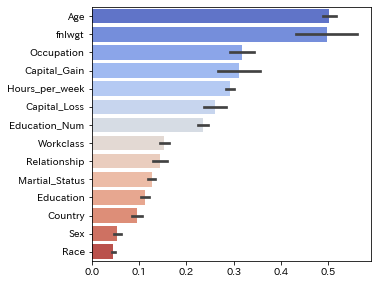

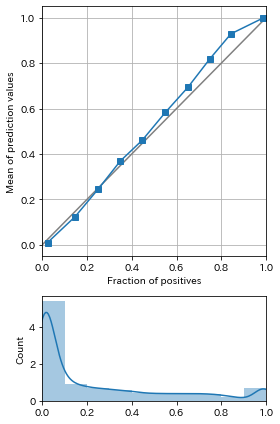

In [35]:
validator.plot_feature_importance(),
validator.plot_calibration_curve(data=(features, labels))

This one is an intuitive cross validation, in which models are fit to each fold.